Phi: -3.5259624590553402 degrees
Theta: 45.9109999999837 degrees
Launch delay: 0.6273102910027499 seconds
Precision: 0.6696368946881474 mm
[-2.6597168  -2.62206177 -2.58590967 -2.55075122 -2.51646021 -2.48366894
 -2.45000659 -2.41309155 -2.31648877 -2.22057251 -2.12527466 -2.03091431
 -1.99955005 -1.96830444 -1.93734204 -1.90612024 -1.87533716 -1.84424499
 -1.81324988 -1.78207898 -1.75126147 -1.72048157 -1.68985559 -1.6591543
 -1.62852368 -1.59801636 -1.56755493 -1.53718567 -1.50696606 -1.47633264
 -1.44603235 -1.41563574 -1.38521875 -1.35488916 -1.32438477 -1.29403076
 -1.26351965 -1.23386231 -1.20387756 -1.17393921 -1.14389563 -1.11387805
 -1.08417346 -1.05464038 -1.0250603  -0.99544446 -0.96585632 -0.93626178
 -0.90689569 -0.87753259 -0.84742908 -0.81796948 -0.78848883 -0.75922815
 -0.72996979 -0.70076813 -0.67203687 -0.6426106  -0.61354163 -0.58453418
 -0.55563684 -0.52661517 -0.49809936 -0.46913467 -0.44023526 -0.41147775
 -0.38264224 -0.35392276 -0.32490543 -0.29623273 -0.2674154

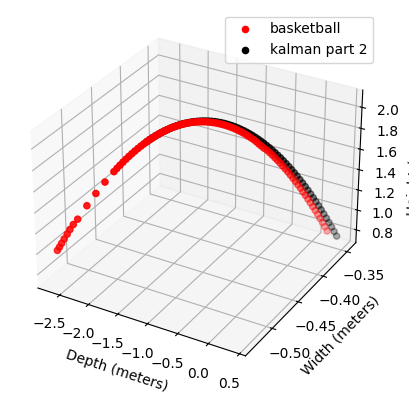

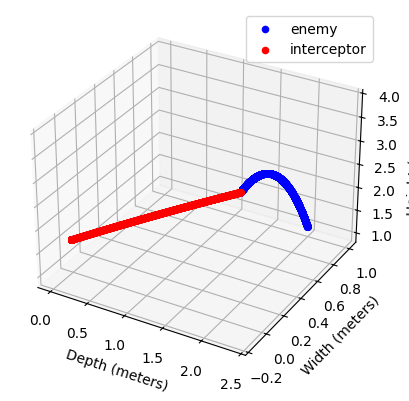

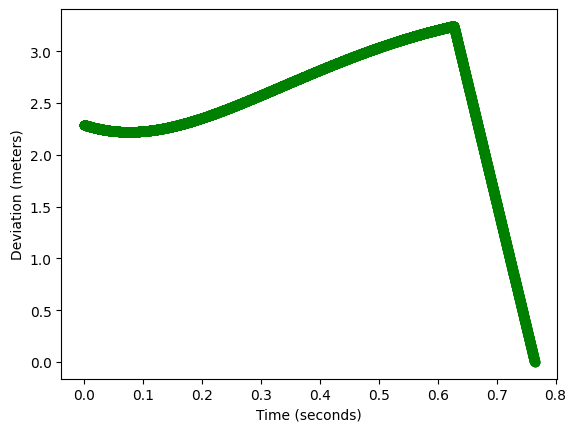

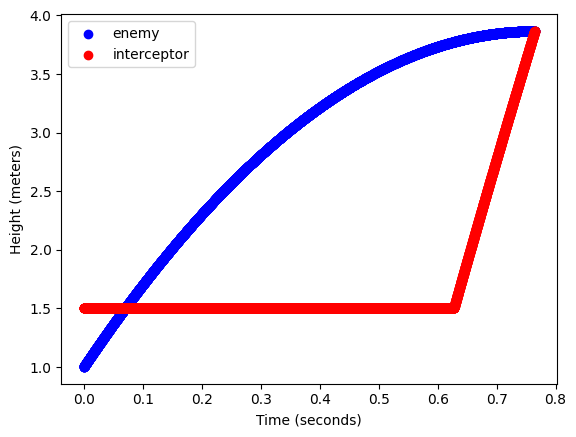

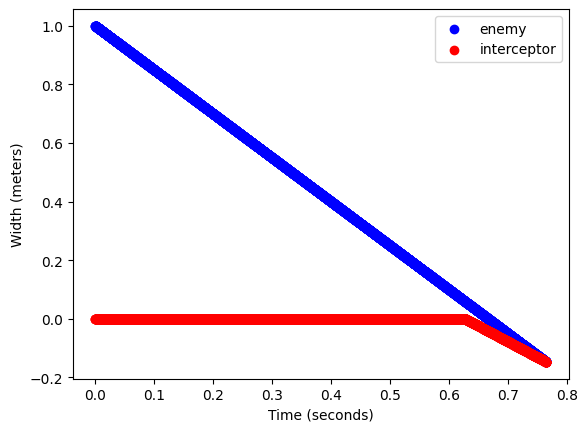

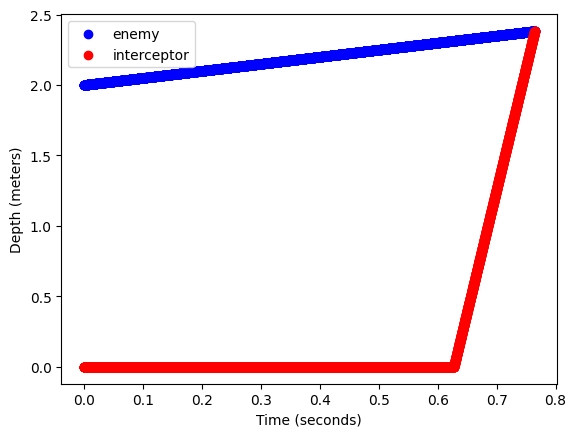

In [48]:


import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import matplotlib.animation as animation
from sympy import Symbol, solve
from math import*
from pykalman import KalmanFilter

# Inacurracies:

timing_error = .002 * 0 # seconds
pitch_error = 0.2 * 0 # degrees
yaw_error = 0.2 * 0 # degrees
observed_position_error = -.003 * 0 # meters
observed_velocity_error = -.003 * 0 # meters per second
muzzle_velocity_error = -.447 * .2 * 0 # meters per second

# Observed Enemy Projectile Characteristics

x_a_0 = 2
y_a_0 = 1
z_a_0 = 1

v_x_a_0 = 0.5
v_y_a_0 = 7.5
v_z_a_0 = -1.5

# Actual Enemy Projectile Characteristics

x_a_A = x_a_0 + observed_position_error
y_a_A = y_a_0 + observed_position_error
z_a_A = z_a_0 + observed_position_error

v_x_a_A = v_x_a_0 + observed_velocity_error
v_y_a_A = v_y_a_0 + observed_velocity_error
v_z_a_A = v_z_a_0 + observed_velocity_error

# Known Launcher Charachteristics

y_b_0 = 1.5
x_b_0 = 0
z_b_0 = 0

v_b_0 = 25

# Actual Launcher Charachteristics

v_b_A = v_b_0 + muzzle_velocity_error

# Gravity

g = 9.81

# Apex Calculation

T_hit = v_y_a_0/g

# Solving for Launcher Yaw

Z_hit = z_a_0 + v_z_a_0 * T_hit
X_hit = x_a_0 + v_x_a_0 * T_hit
phi = degrees(atan((Z_hit/X_hit)))
dxy = cos(radians(phi))
dz = sin(radians(phi))

phi_A = phi + yaw_error
dxy_A = cos(radians(phi_A))
dz_A = sin(radians(phi_A))

print(f'Phi: {phi} degrees')

# Solving for Launcher Pitch

Theta = 0

for degree in range(90000):

  dT = ((x_a_0 - x_b_0 + v_x_a_0*T_hit)/(v_b_0 * cos(radians(Theta))*dxy))

  Y_a = y_a_0 + (v_y_a_0**2) * (1/g - 1/(2*g))
  Y_b = y_b_0 + v_b_0 * sin(radians(Theta))*dxy*dT - (g/2)*(dT**2)

  if abs(Y_b - Y_a) < .0001:
    theta = Theta
    break

  Theta += .001

Theta_A = Theta + pitch_error

print(f'Theta: {theta} degrees')

# Solving for Launch Delay

t_launch = T_hit - ((x_a_0 - x_b_0 + v_x_a_0*T_hit)/(v_b_0 * cos(radians(theta))*dxy))

t_launch_A = t_launch + timing_error

print(f'Launch delay: {t_launch} seconds')

# Run simulation

t = 0

x_a = []
y_a = []
z_a = []

x_b = []
y_b = []
z_b = []

T = []

Deviation = []

while t <= (T_hit + .25*0):
    t += 0.0001

    t_2 = max(t - t_launch_A, 0)

    X_a = v_x_a_A * t + x_a_A
    Y_a = y_a_A + v_y_a_A * t - (g/2)*(t**2)
    Z_a = v_z_a_A * t + z_a_A

    x_a.append(X_a)
    y_a.append(Y_a)
    z_a.append(Z_a)

    X_b = (v_b_A * cos(radians(Theta_A))*dxy_A * t_2)
    Y_b = (y_b_0 + v_b_A * sin(radians(Theta_A))* dxy_A * t_2 - (g/2)*(t_2**2))
    Z_b = (v_b_A * cos(radians(Theta_A))*dz_A * t_2)

    x_b.append(X_b)
    y_b.append(Y_b)
    z_b.append(Z_b)

    T.append(t)

    Deviation.append((((X_a-X_b)**2)+((Y_a-Y_b)**2)+((Z_a-Z_b)**2))**0.5)


print(f'Precision: {1000*min(Deviation)} mm')

#kalman filter stuff


#projectile_df = pd.read_csv('projectile-basket-ball 1.csv',index_col='Frame')
time1 = time.time()
projectile_df = pd.read_csv('projectile-interception-regular 2.csv',index_col='Frame')
projectile_df = projectile_df.dropna()
basketball_x = projectile_df['TX'].values
basketball_x = basketball_x / 1000
basketball_x = basketball_x[140:230]
basketball_y = projectile_df['TZ'].values
basketball_y = basketball_y / 1000
basketball_y = basketball_y[140:230]
basketball_z = projectile_df['TY'].values
basketball_z = basketball_z / 1000
basketball_z = basketball_z[140:230]
print(basketball_x)
print(basketball_y)
print(basketball_z)
print(len(basketball_x))
print(len(basketball_y))
print(len(basketball_z))


framerate = 100 
initial_distance = basketball_y[1]-basketball_y[0]
initial_velocity = (basketball_y[1]-basketball_y[0]) * framerate 
print(initial_distance)
print(initial_velocity)
#sys.exit(1)
dt = 1 / framerate
initial_state = np.asarray([x_a[0],y_a[0],z_a[0],0,0,0,0,-1*g,0])
print(dT)
transition_matrix = np.asarray(
    [
        [1., 0., 0., dT, 0., 0., 0., 0., 0.], # x pos
        [0., 1., 0., 0., dT, 0., 0., 0., 0.], # y pos
        [0., 0., 1., 0., 0., dT, 0., 0., 0.], # z pos
        [0., 0., 0., 1., 0., 0., 0., 0., 0.], # x velocity
        [0., 0., 0., 0., 1., 0., 0., dT, 0.], # y velocity
        [0., 0., 0., 0., 0., 1., 0., 0., 0.], # z velocity
        [0., 0., 0., 0., 0., 0., 1., 0., 0.], # x accel
        [0., 0., 0., 0., 0., 0., 0., 1., 0.], # y accel
        [0., 0., 0., 0., 0., 0., 0., 0., 1.] # z accel
    ]
)
observation_matrix = np.asarray(
    [
        [1, 0, 0, 0, 0, 0,0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0]
    ]
)





kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state)
measurements = []

for values in zip(basketball_x,basketball_y,basketball_z):
  measurements.append(values)
#measurements = measurements[0::100]


shrink_factor =4

measurements = measurements[0::int(len(measurements)/60)]
print(len(measurements[:int(len(measurements)//shrink_factor)]))

kf1 = kf1.em(measurements[:int(len(measurements)//shrink_factor)], n_iter=20)

(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements[:int(len(measurements)//shrink_factor)])
next_mean = smoothed_state_means[-1]
next_covar = smoothed_state_covariances[-1]
second_half = measurements[int(len(measurements)//shrink_factor):]
predicted_error = []
predicted_state_means = []
predicated_state_covariances = []
for measure in second_half:
  next_mean, next_covar = kf1.filter_update(next_mean,next_covar)
  predicted_state_means.append(next_mean)
  predicated_state_covariances.append(next_covar)
  error = next_mean[0:3] - measure
  predicted_error.append(error)
time2 = time.time()
print("Time for kalman filter is " + str(time2-time1) + " seconds")
print(predicted_error[-1])

errors = []
for coordinates in zip(smoothed_state_means[:,0:3], measurements):
  error = coordinates[0] - coordinates[1]
  errors.append(error)
#print(errors)
predicted_state_means = np.array(predicted_state_means)
# Plotting
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(basketball_x, basketball_z, basketball_y, c = 'red', label = "basketball")
#ax.scatter(x_a, z_a, y_a, c = 'blue', label = "enemy")
#ax.scatter(x_b, z_b, y_b, c = 'red', label = "interceptor")
#ax.scatter(smoothed_state_means[:,0],smoothed_state_means[:,2],smoothed_state_means[:,1], c="orange", label = "kalman part 1")
ax.scatter(predicted_state_means[:,0],predicted_state_means[:,2],predicted_state_means[:,1], c="black", label = "kalman part 2")
ax.legend()
ax.set_xlabel("Depth (meters)")
ax.set_zlabel("Height (meters)")
ax.set_ylabel("Width (meters)")


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_a, z_a, y_a, c = 'blue', label = "enemy")

ax.scatter(x_b, z_b, y_b, c = 'red', label = "interceptor")
#ax.scatter(smoothed_state_means[:,0],smoothed_state_means[:,2],smoothed_state_means[:,1], c="orange", label = "kalman part 1")
#ax.scatter(predicted_state_means[:,0],predicted_state_means[:,2],predicted_state_means[:,1], c="black", label = "kalman part 2")
ax.legend()
ax.set_xlabel("Depth (meters)")
ax.set_zlabel("Height (meters)")
ax.set_ylabel("Width (meters)")


plt.figure()
plt.scatter(T, Deviation, c = 'green')
plt.xlabel("Time (seconds)")
plt.ylabel("Deviation (meters)")
plt.show()

plt.figure()
plt.scatter(T, y_a, c = 'blue', label = "enemy")
plt.scatter(T, y_b, c = 'red', label = "interceptor")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Height (meters)")
plt.show()

plt.figure()
plt.scatter(T, z_a, c = 'blue', label = "enemy")
plt.scatter(T, z_b, c = 'red', label = "interceptor")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Width (meters)")
plt.show()

plt.figure()
plt.scatter(T, x_a, c = 'blue', label = "enemy")
plt.scatter(T, x_b, c = 'red', label = "interceptor")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Depth (meters)")
plt.show()